In [1]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

แบ่งข้อมูล

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_csv("500 เมนู label แล้ว - Sheet1.csv")

train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)


train_df.to_csv("train_set.csv", index=False, encoding='utf-8-sig')
val_df.to_csv("val_set.csv", index=False, encoding='utf-8-sig')
test_df.to_csv("test_set.csv", index=False, encoding='utf-8-sig')

print("Data has been split and saved to train_set.csv, val_set.csv, and test_set.csv.")

Data has been split and saved to train_set.csv, val_set.csv, and test_set.csv.


In [4]:
import pandas as pd

df = pd.read_csv("test_set.csv")

ingredient_texts = df["วัตถุดิบ"].tolist()
recipe_names = df["ชื่ออาหาร"].tolist()

ingredient_embeddings = model.encode(ingredient_texts, convert_to_tensor=True)
recipe_name_embeddings = model.encode(recipe_names, convert_to_tensor=True)

In [11]:

import pandas as pd
from sentence_transformers import SentenceTransformer, util

# Load model
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# Load dataset
df = pd.read_csv("test_set.csv")

# Get cleaned ingredient texts and recipe names
ingredient_texts = df["วัตถุดิบ"].astype(str).tolist()
recipe_names = df["ชื่ออาหาร"].astype(str).tolist()

# Encode all dataset ingredient lists (only once)
ingredient_embeddings = model.encode(ingredient_texts, convert_to_tensor=True)



ทำให้ query บอกวัตถุดิบไม่ครบ สะกดผิด

In [26]:
import pandas as pd
import random
import ast

def add_typo(word, typo_prob=0.2):
    if random.random() > typo_prob or len(word) < 2:
        return word

    typo_type = random.choice(["delete", "swap", "replace"])
    idx = random.randint(0, len(word)-2)

    if typo_type == "delete":
        return word[:idx] + word[idx+1:]
    elif typo_type == "swap":
        return word[:idx] + word[idx+1] + word[idx] + word[idx+2:]
    elif typo_type == "replace":
        replacements = "กขคฆงจฉชซฌญฎฏฐฑฒณดตถทธนบปผฝพฟภมยรฤลฦวศษสหฬอฮ"
        return word[:idx] + random.choice(replacements) + word[idx+1:]
    return word

def prepare_partial_noisy_ingredients_dict(json_str, pick_min=0.6, pick_max=0.9, typo_prob=0.2):
    try:
        # Safely parse string to dict
        ing_dict = ast.literal_eval(json_str)
        if not isinstance(ing_dict, dict):
            return ""

        ingredients = list(ing_dict.keys())
        if not ingredients:
            return ""

        pick_count = random.randint(int(len(ingredients) * pick_min), max(int(len(ingredients) * pick_max), 1))
        sampled = random.sample(ingredients, pick_count)

        # Apply typos
        noisy = [add_typo(ing, typo_prob) for ing in sampled]
        return ", ".join(noisy)

    except Exception as e:
        return ""

# Load CSV
df = pd.read_csv("test_set.csv")

# Apply to all rows
df["partial_noisy_ingredients"] = df["ingredient_full_json"].astype(str).apply(prepare_partial_noisy_ingredients_dict)

# Save result
df.to_csv("test_set_with_clean_partial_noisy.csv", index=False)

print("✅ Clean ingredient names with typos saved to 'test_set_with_clean_partial_noisy.csv'")


✅ Clean ingredient names with typos saved to 'test_set_with_clean_partial_noisy.csv'


บางช่องไม่มีข้อมูลเลยมาใส่มือ

In [33]:
from google.colab import sheets
import pandas as pd

# Load the dataframe as it was done previously
df = pd.read_csv("test_set_with_clean_partial_noisy.csv")

# Pass the pandas DataFrame directly to the InteractiveSheet
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1XlzXbtwrlam-jj0WfrGhaUANQDhdK_rlah3UiLAm7VU/edit#gid=0


Accuracy@1: 0.27
Accuracy@3: 0.40


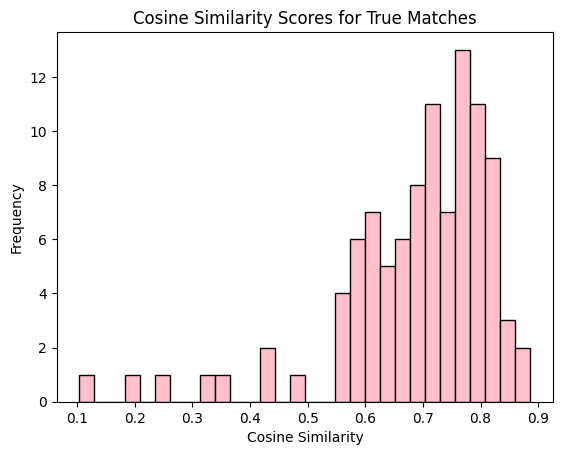

In [43]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt # Import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("test set noisy 100 edit - Sheet1.csv")

# Load your model
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')


# Prepare data
noisy_queries = df["partial_noisy_ingredients"].astype(str).tolist()
clean_references = df["วัตถุดิบ"].astype(str).tolist()

# Encode clean ingredients once
clean_embeddings = model.encode(clean_references, convert_to_tensor=True)

# Variables to store results
correct_top1 = 0
correct_top3 = 0
cosine_scores_true_match = []

total = len(df)

for i in range(total):
    query = noisy_queries[i]
    query_emb = model.encode(query, convert_to_tensor=True)

    # Compute cosine similarity against all clean references
    cos_scores = util.cos_sim(query_emb, clean_embeddings)[0]

    # Get top 3 indices with highest similarity scores
    top_k = 3
    top_k_indices = cos_scores.topk(k=top_k).indices.cpu().numpy()

    # Check if true match (index i) is within top 1 or top 3
    if top_k_indices[0] == i:
        correct_top1 += 1
    if i in top_k_indices:
        correct_top3 += 1

    # Record cosine similarity score of the true match (row i)
    cosine_scores_true_match.append(cos_scores[i].item())

# Calculate accuracy
accuracy_top1 = correct_top1 / total
accuracy_top3 = correct_top3 / total

print(f"Accuracy@1: {accuracy_top1:.2f}")
print(f"Accuracy@3: {accuracy_top3:.2f}")

# Analyze cosine similarity distribution for true matches
plt.hist(cosine_scores_true_match, bins=30, color='pink', edgecolor='black')
plt.title("Cosine Similarity Scores for True Matches")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

ลองแยกเล่นเมนู

In [44]:
query = "ปลาทู, กะปิ, น้ำมะนาว, กระเทียม, พริกขี้หนู"
recipe, score = find_closest_recipe(query)

print(f"Closest recipe: {recipe}")
print(f"Similarity score: {score:.2f}")


Closest recipe: น้ำพริกมะอึก
Similarity score: 0.97
